# Toy Example - In-Memory GiGL

Latest version of this notebook can be found on [github](https://github.com/Snapchat/GiGL/blob/main/examples/tutorial/KDD_2025/heterogeneous_walkthrough.ipynb)


This notebook provides a walkthrough of preprocessing components with a small toy graph for GiGL's in-memory setting for training/inference. It will help you understand how each of these components perform in-memory training and inference.


## Overview Of Components
This notebook demonstrates the process of a simple, human-digestible graph being passed through all the pipeline components in GiGL in preparation for training to help understand how each of the components work.

The pipeline consists of the following components:

- **Config Populator**: Takes a template config and creates a frozen workflow config that dictates all inputs/outputs and business parameters that are read and used by each subsequent component.
    - Input: `template_config.yaml`
    - Output: `frozen_gbml_config.yaml`
&nbsp;

- **Data Preprocessor**: Transforms necessary node and edge feature assets as needed as a precursor step in most ML tasks according to the user-provided data preprocessor config class.
    - Input: `frozen_gbml_config.yaml`, which includes the user-defined preprocessor class for custom logic, and custom arguments can be passed under dataPreprocessorArgs.
    - Output: PreprocessedMetadata Proto, which includes inferred GraphMetadata and preprocessed graph data Tfrecords after applying the user-defined preprocessing function.
&nbsp;

- **Trainer**: The trainer component reads the output of the data preprocessor and trains a model on the data, loading subgraphs on-the-fly by leveraging GiGL's distributed in-memory capabilities.
    - Input: `frozen_gbml_config.yaml`
    - Output: state_dict stored in trainedModelUri.
&nbsp;

- **Inferencer**: Runs inference of a trained model, leveraging the same in-memory subgraph sampling capabilities, and writes the embeddings to BigQuery.
    - Input: `frozen_gbml_config.yaml`
    - Output: Embeddings assets.
&nbsp;


In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress TensorFlow logs


from gigl.common.utils.jupyter_magics import change_working_dir_to_gigl_root
change_working_dir_to_gigl_root()

Changed working directory to: /home/mkolodner/BAGL/GiGL


## Visualize the dataset

First, let's visualize the toy graph :)

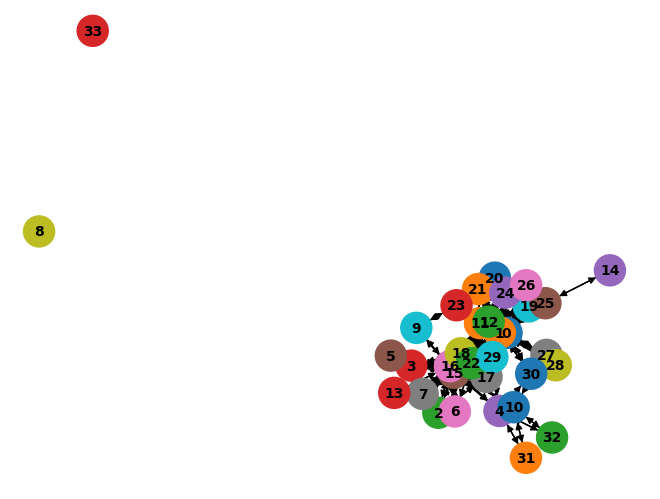

In [2]:
from torch_geometric.data import HeteroData

from gigl.common.utils.jupyter_magics import GraphVisualizer
from gigl.src.mocking.toy_asset_mocker import load_toy_graph


original_graph_heterodata: HeteroData = load_toy_graph(graph_config_path="examples/tutorial/KDD_2025/graph_config.yaml")
# Visualize the graph
GraphVisualizer.visualize_graph(original_graph_heterodata)

### Setting up Configs

The first thing we need to do is create the resource and task configs. 

- **Task Config**: Specifies task-related configurations, guiding the behavior of components according to the needs of your machine learning task. See [Task Config Guide](../../docs/user_guide/config_guides/task_config_guide.md). For this task, we have already provided a task config: [task_config.yaml](./task_config.yaml).

- **Resource Config**: Details the resource allocation and environmental settings across all GiGL components. This encompasses shared resources for all components, as well as component-specific settings. See [Resource Config Guide](../../docs/user_guide/config_guides/resource_config_guide.md). For this task, we provide a resource [resource_config.yaml](./resource_config.yaml). The provided default values in `shared_resource_config.common_compute_config` will need to be changed.

  - **Instructions to configure the resource config to work**:
    If you have not already, please follow the [Quick Start Guide](../../docs/user_guide/getting_started/quick_start.md) to set up your cloud environment and create a default test resource config. You can then copy the relevant `shared_resource_config.common_compute_config` to [resource_config.yaml](./resource_config.yaml).

In [ ]:
import datetime
import getpass
import pathlib
import os


from gigl.common import Uri, UriFactory
from gigl.common.constants import DEFAULT_GIGL_RELEASE_SRC_IMAGE_DATAFLOW_CPU, DEFAULT_GIGL_RELEASE_SRC_IMAGE_CUDA, DEFAULT_GIGL_RELEASE_SRC_IMAGE_CPU

#DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG = DEFAULT_GIGL_RELEASE_SRC_IMAGE_DATAFLOW_CPU

# TODO (mkolodner-sc): Remove this line once GiGL is released 
DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG = "us-central1-docker.pkg.dev/external-snap-ci-github-gigl/public-gigl/src-cuda:0.0.3.dev20250725171252"

notebook_dir = pathlib.Path("./examples/tutorial/KDD_2025").as_posix() # We should be in root dir because of cell # 1

# You are welcome to customize these  to point to your own configuration files.
JOB_NAME = f"{getpass.getuser()}_gigl_toy_example_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
TEMPLATE_TASK_CONFIG_PATH: Uri = UriFactory.create_uri(f"{notebook_dir}/task_config.yaml")
FROZEN_TASK_CONFIG_POINTER_FILE_PATH: Uri = UriFactory.create_uri(f"/tmp/GiGL/{JOB_NAME}/frozen_task_config.yaml")
pathlib.Path(FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri).parent.mkdir(parents=True, exist_ok=True)
# Ensure you change the resource config path to point to your own resource configuration
# i.e. what was exported to $GIGL_TEST_DEFAULT_RESOURCE_CONFIG as part of the quick start guide.
RESOURCE_CONFIG_PATH: Uri = UriFactory.create_uri(os.environ.get("GIGL_TEST_DEFAULT_RESOURCE_CONFIG", f"{notebook_dir}/resource_config.yaml"))

# Export string format of the uris so we can reference them in cells that execute bash commands below.
os.environ["TEMPLATE_TASK_CONFIG_PATH"] = TEMPLATE_TASK_CONFIG_PATH.uri
os.environ["FROZEN_TASK_CONFIG_POINTER_FILE_PATH"] = FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri
os.environ["RESOURCE_CONFIG_PATH"] = RESOURCE_CONFIG_PATH.uri

print(f"JOB_NAME: {JOB_NAME}")
print(f"TEMPLATE_TASK_CONFIG_PATH: {TEMPLATE_TASK_CONFIG_PATH.uri}")
print(f"FROZEN_TASK_CONFIG_POINTER_FILE_PATH: {FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri}")
print(f"RESOURCE_CONFIG_PATH: {RESOURCE_CONFIG_PATH.uri}")

## Validating the Configs

We provide the ability to validate your resource and task configs. Although the validation is not exhaustive, it does help assert that the more common issues are not present before expensive compute is scheduled.

In [ ]:
from gigl.src.validation_check.config_validator import kfp_validation_checks

validator = kfp_validation_checks(
    job_name=JOB_NAME,
    task_config_uri=TEMPLATE_TASK_CONFIG_PATH,
    resource_config_uri=RESOURCE_CONFIG_PATH,
    start_at="config_populator",
)

### Config Populator

Takes in a template `GbmlConfig` and outputs a frozen `GbmlConfig` by populating all job-related metadata paths in `sharedConfig`. These are mostly GCS paths that the following components read and write from, and use as an intermediary data communication medium. For example, the field `sharedConfig.trainedModelMetadata` is populated with a GCS URI, which indicates to the Trainer to write the trained model to this path, and to the Inferencer to read the model from this path. See the full [Config Populator Guide](../../docs/user_guide/overview/components/config_populator.md).

After running the command below, we will have created a frozen config and uploaded it to the `perm_assets_bucket` provided in the `resource config`. The path to that file will be stored in the file at `FROZEN_TASK_CONFIG_POINTER_FILE_PATH`.

In [ ]:
%%capture
# We suppress the output of this cell to avoid cluttering the notebook with logs. Remove %%%capture if you want to see the output.

!python -m \
    gigl.src.config_populator.config_populator \
    --job_name="$JOB_NAME" \
    --template_uri="$TEMPLATE_TASK_CONFIG_PATH" \
    --resource_config_uri="$RESOURCE_CONFIG_PATH" \
    --output_file_path_frozen_gbml_config_uri="$FROZEN_TASK_CONFIG_POINTER_FILE_PATH"

In [ ]:
# The command above will write the frozen task config path to the file specified by `FROZEN_TASK_CONFIG_POINTER_FILE_PATH`.
# Lets see where it was generated
FROZEN_TASK_CONFIG_PATH: Uri
with open(FROZEN_TASK_CONFIG_POINTER_FILE_PATH.uri, 'r') as file:
    FROZEN_TASK_CONFIG_PATH = UriFactory.create_uri(file.read().strip())
print(f"FROZEN_TASK_CONFIG_PATH: {FROZEN_TASK_CONFIG_PATH}")

# Data Preprocessor

Once we have a `frozen_task_config`, the first step is to preprocess the data.

The Data Preprocessor component uses [Tensorflow Transform](https://www.tensorflow.org/tfx/transform/get_started) to achieve data transformation in a distributed fashion. 

- Any custom preprocessing is to be defined in the preprocessor class, specified in the task config by `datasetConfig.dataPreprocessorConfig.dataPreprocessorConfigClsPath`.
- This class must inherit from {py:class}`gigl.src.data_preprocessor.lib.data_preprocessor_config.DataPreprocessorConfig`.

In your preprocessor spec, you must implement the following 3 functions as defined by the base class `DataPreprocessorConfig`:
  - `prepare_for_pipeline`: Preparing datasets for ingestion and transformation.
  - `get_nodes_preprocessing_spec`: Defining transformation imperatives for different node types.
  - `get_edges_preprocessing_spec`: Defining transformation imperatives for different edge types.

Please take a look at [preprocessor_config.py](./preprocessor_config.py) to see how these are defined. You will note that in this case, we are not doing anything special (i.e., no feature engineering), just reading from BQ and passing through the features. We could, if we wanted, define our own [preprocessing function](https://www.tensorflow.org/tfx/transform/get_started#preprocessing_function_example), and replace it with `build_passthrough_transform_preprocessing_fn()` defined in the code.

### Input Parameters and Output Paths for Data Preprocessor
Let's take a quick look at what these are from our frozen config.

In [ ]:

# We will load the frozen task and resource configs file into an object so we can reference it
from gigl.env.pipelines_config import get_resource_config
from gigl.src.common.types.pb_wrappers.gbml_config import GbmlConfigPbWrapper
from gigl.src.common.types.pb_wrappers.gigl_resource_config import GiglResourceConfigWrapper
import textwrap

frozen_task_config = GbmlConfigPbWrapper.get_gbml_config_pb_wrapper_from_uri(
    gbml_config_uri=FROZEN_TASK_CONFIG_PATH
)
resource_config: GiglResourceConfigWrapper = get_resource_config(
    resource_config_uri=RESOURCE_CONFIG_PATH
)

print("Frozen Config DataPreprocessor Information:")

print("- Data Preprocessor Config: Specifies what class to use for datapreprocessing and any arguments that might be passed in at runtime to that class")
print(textwrap.indent(str(frozen_task_config.dataset_config.data_preprocessor_config), '\t'))
print("- Preprocessed Metadata Uri: Specifies path to the preprocessed metadata file that will be generated by this component and used by subsequent components to understand and find the data that was preprocessed")
print(textwrap.indent(str(frozen_task_config.shared_config.preprocessed_metadata_uri), '\t'))

### Running Data Preprocessor and visualizing the Preprocessed Metadata

In [ ]:
%%capture

!python -m gigl.src.data_preprocessor.data_preprocessor \
--job_name=$JOB_NAME \
--task_config_uri=$FROZEN_TASK_CONFIG_PATH \
--resource_config_uri=$RESOURCE_CONFIG_PATH \
--custom_worker_image_uri=$DOCKER_IMAGE_DATAFLOW_RUNTIME_NAME_WITH_TAG

In [ ]:
# Upon completion of job, we will see the preprocessed metadata be populated

frozen_task_config = GbmlConfigPbWrapper.get_gbml_config_pb_wrapper_from_uri(
    gbml_config_uri=FROZEN_TASK_CONFIG_PATH
)
preprocessed_metadata_pb = frozen_task_config.preprocessed_metadata_pb_wrapper.preprocessed_metadata_pb
print(preprocessed_metadata_pb)

You do not have to worry about these details in code as it is all handled by the data preprocessor component and subsequent data loaders
But, for the sake of understanding, we will investigate the condensed_node_type = 0 and condensed_edge_type = 0
If you remember the from the frozen config the mappings were as follows:

In [ ]:
print("Condensed Node Type Mapping:")
print(textwrap.indent(str(frozen_task_config.graph_metadata.condensed_node_type_map), '\t'))
print("Condensed Edge Type Mapping:")
print(textwrap.indent(str(frozen_task_config.graph_metadata.condensed_edge_type_map), '\t'))

preprocessed_nodes = preprocessed_metadata_pb.condensed_node_type_to_preprocessed_metadata[0].tfrecord_uri_prefix
preprocessed_edges = preprocessed_metadata_pb.condensed_edge_type_to_preprocessed_metadata[0].main_edge_info.tfrecord_uri_prefix
print(f"Preprocessed Nodes are stored in: {preprocessed_nodes}")
print(f"Preprocessed Edges are stored in: {preprocessed_edges}")

There is not a lot of data so we will have likely just generated one file for each of the preprocessed nodes and edges.

In [ ]:
!gsutil ls $preprocessed_nodes && gsutil ls $preprocessed_edges

In [ ]:
# Do a simple forward/backward pass of the model

# TODO(mkolodner): Swap to the on-the-fly task config from pre-populator.
task_config_uri = "examples/tutorial/KDD_2025/toy_graph_task_config.yaml"
# First, we need to load the dataset
import torch

from gigl.distributed import (
    DistLinkPredictionDataset,
    build_dataset_from_task_config_uri,
)
# GiGL is meant to operate in a very large distributed setting, so we need to initialize the process group.
torch.distributed.init_process_group(
    backend="gloo",  # Use the Gloo backend for CPU training.
    init_method="tcp://localhost:29500",
    rank=0,
    world_size=1,
)

# `build_dataset_from_task_config_uri` is a utility function
# to build a dataset in a distributed manner.
# It will:
# 1. Read the serialized graph data whose located is specified in the task config.
# 2. Load the graph data in a distributed manner.
# 3. Partition the graph data into shards for distributed training.
# 4. Optional: If training, will generate splits for training.
dataset: DistLinkPredictionDataset = build_dataset_from_task_config_uri(
        task_config_uri=task_config_uri,
        is_inference=False,
        _tfrecord_uri_pattern=".*tfrecord", # Our example data uses a different tfrecord pattern.
)

# And instantiate a dataloader:
from gigl.distributed import DistABLPLoader

loader = DistABLPLoader(
            dataset=dataset,
            num_neighbors=[2, 2],  # Example neighbor sampling configuration.
            input_nodes=("user", torch.tensor([0])),  # Example input nodes, adjust as needed.
            batch_size=1,
            supervision_edge_type=("user", "to", "story"),  # Supervision edge type defined in the graph.
            pin_memory_device=torch.device(
                "cpu"
            ),  # Only CPU training for this example.
        )
data: HeteroData = next(iter(loader))

In [ ]:
# Now let's look at the data we just loaded.
print(data)

# You might notice a few things about the data that is different from vanilla PyG:
# * num_sampled_nodes and num_sampled_edges are present,
# * representing the number of nodes and edges sampled per hop.
# * y_positive is added, and is a dict of anchor node -> target nodes.

GraphVisualizer.visualize_graph(data)

In [ ]:
# Initialize a model and do a forward pass
# You can interop with any PyG model, but we will use HGTConv for this example.
from torch_geometric.nn import HGTConv

model = HGTConv(
    in_channels=data.num_node_features,
    out_channels=16,  # Example output dimension.
    metadata=data.metadata(),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

# Do a forward pass
embeddings = model(data.x_dict, data.edge_index_dict)

print(f"Embeddings: {embeddings}")

In [ ]:
# Now let's define a loss function for the link prediction task.
# TODO should we define this in some util file?

# Note that we really should wrap this

def compute_loss(model: torch.nn.Module, data: HeteroData) -> torch.Tensor:
    main_out: dict[str, torch.Tensor] = model(data.x_dict, data.edge_index_dict)
    # data.y_positive = {
    #   0: [1, 2],
    #   1: [3, 4, 5],
    # }
    anchor_nodes = torch.arange(data["user"].batch_size).repeat_interleave(
        torch.tensor([len(v) for v in data.y_positive.values()])
    )
    # anchor_nodes = [0, 0, 1, 1, 1]
    target_nodes = torch.cat([v for v in data.y_positive.values()])
    # target_nodes = [1, 2, 3, 4, 5]
    # Use MarginRankingLoss for link prediction
    loss_fn = torch.nn.MarginRankingLoss()
    query_embeddings = main_out["user"][anchor_nodes]
    target_embeddings = main_out["story"][target_nodes]
    loss = loss_fn(
        input1=query_embeddings,
        input2=target_embeddings,
        target=torch.ones_like(query_embeddings, dtype=torch.float32),
    )
    return loss

# Note that in practice you would want to wrap this in a training loop
# but for this example doing just one pass is sufficient.
# A training loop example can be found in:
# examples/tutorial/KDD_2025/heterogeneous_training.py
loss = compute_loss(model, data)
print(f"Loss: {loss.item()}")

# And we can do a backward pass
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
# Now if we run the loss function again, we should see a different value.
loss = compute_loss(model, data)
print(f"Loss after backward pass: {loss.item()}")

In [ ]:
print(f"{dataset.node_ids}")

In [ ]:
# Now that we've "Trained" the model, let's do inference on it.
# Note that inference is very similar to training, but we don't need to do a backward pass.
# And we should use the `DistNeighborloader` instead of `DistABLPLoader`
from gigl.distributed import DistNeighborLoader
inference_loader = DistNeighborLoader(
    dataset=dataset,
    num_neighbors=[2, 2],  # Example neighbor sampling configuration.
    input_nodes=("user", torch.tensor([0, 1, 2, 3])),  # Run inference against some of the nodes. In a custom datasets you would use `dataset.node_ids['user']`.
    batch_size=1,
    pin_memory_device=torch.device("cpu"),  # Only CPU training for this example.
)

# GiGL has an "EmbeddingExporter" to write out the embeddings to disk or GCS. We export embeddings to a local file in this example. 
from gigl.common import UriFactory
from gigl.common.data.export import EmbeddingExporter

# Use a local directory for exporting embeddings.
# You can also use a GCS URI if you want to export to GCS.
# For example, use "gs://your-bucket-name/path/to/embeddings".
embedding_dir = UriFactory.create_uri("examples/tutorial/KDD_2025/.embeddings")

exporter = EmbeddingExporter(
    export_dir=embedding_dir,
)
with torch.no_grad():
    for data in inference_loader:
        embeddings = model(data.x_dict, data.edge_index_dict)
        exporter.add_embedding(
            id_batch=data["user"].batch,
            embedding_batch=embeddings["user"],
            embedding_type="user"
        )
    exporter.flush_embeddings()

In [ ]:
# Look at the exported embeddings
!ls examples/tutorial/KDD_2025/.embeddings

In [ ]:
# Now we can load the embeddings from disk and load them into a dataframe.
from pathlib import Path
import fastavro

avro_records = []
for file in Path("examples/tutorial/KDD_2025/.embeddings").glob("*.avro"):
    with open(file, "rb") as f:
        reader = fastavro.reader(f)
        for record in reader:
            avro_records.append(record)
print(f"Loaded {len(avro_records)} records from the avro files.")
print(f"First record: {avro_records[0]}")

# And load them into a dataframe.
import pandas as pd
df = pd.DataFrame.from_records(avro_records)
print(f"Dataframe:\n{df}")
# GiGL also has gigl.common.data.export.load_embeddings_to_bigquery
# Which you can use to load the embeddings into BigQuery.